In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/csv files/final_df.csv')
df.set_index('title', inplace=True)

# Define criteria for categorizing movie success
def categorize_movie_success(success_value):
    if success_value >= threshold_for_hit:
        return 'hit'
    elif threshold_for_flop <= success_value < threshold_for_hit:
        return 'average'
    else:
        return 'flop'

# Set the thresholds based on your criteria
threshold_for_hit = 0.8  # Define your threshold for a 'hit'
threshold_for_flop = 0.2  # Define your threshold for a 'flop'

In [3]:
X = df.drop(columns=['Movie Success'], axis=1)
y = df['Movie Success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
#Gradient Boosting

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('MAE: ', mean_absolute_error(y_test, predictions))
print('R^2: ', r2_score(y_test, predictions))

MAE:  0.1603021027704963
R^2:  0.3011579399561285


In [5]:
#Random Forest Regressor

model = RandomForestRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('MAE: ', mean_absolute_error(y_test, predictions))
print('R^2: ', r2_score(y_test, predictions))

MAE:  0.16304576151524008
R^2:  0.2670982918157885


In [6]:
X = df.drop(columns=['Movie Success'], axis=1)
y = df['Movie Success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [7]:
#feature engineering

is_best_scaled = None
best_k = None
best_MAE = 1000000000
best_features = None
best_r2 = None
best_pred = None

for i in range(2, 39):
  selector = SelectKBest(f_regression, k=i)
  X_new = selector.fit_transform(X_train, y_train)
  selected_features_bool = selector.get_support()
  selected_features_names = list(X.columns[selected_features_bool])

  model_scaled = SVR()
  model_scaled.fit(X_train_scaled[selected_features_names], y_train)
  predictions = model_scaled.predict(X_test_scaled[selected_features_names])
  mae_scaled = mean_absolute_error(y_test, predictions)
  #print('MAE Scaled, ', i, 'features: ', mae_scaled)

  if mae_scaled < best_MAE:
    is_best_scaled = True
    best_k = i
    best_MAE = mae_scaled
    best_features = selected_features_names
    best_r2 = r2_score(y_test, predictions)
    best_pred = predictions

  model = SVR()
  model.fit(X_train[selected_features_names], y_train)
  predictions = model.predict(X_test[selected_features_names])
  mae = mean_absolute_error(y_test, predictions)
  #print('MAE, ', i, 'features: ', mae)

  if mae < best_MAE:
    is_best_scaled = False
    best_k = i
    best_MAE = mae
    best_features = selected_features_names
    best_r2 = r2_score(y_test, predictions)
    best_pred = predictions

print('Is best MAE scaled: ', is_best_scaled)
print('Best nr of features: ', best_k)
print('Best MAE: ', best_MAE)
print('Best R^2: ', best_r2)
print('Best feature: ', best_features)

Is best MAE scaled:  True
Best nr of features:  5
Best MAE:  0.16233270328411029
Best R^2:  0.3005221556872205
Best feature:  ['Rating', 'Total Ratings', 'Nr Awards', 'Adventure', 'Literary Fiction']


Text(0.5, 1.0, 'actual vs predicted: SVR')

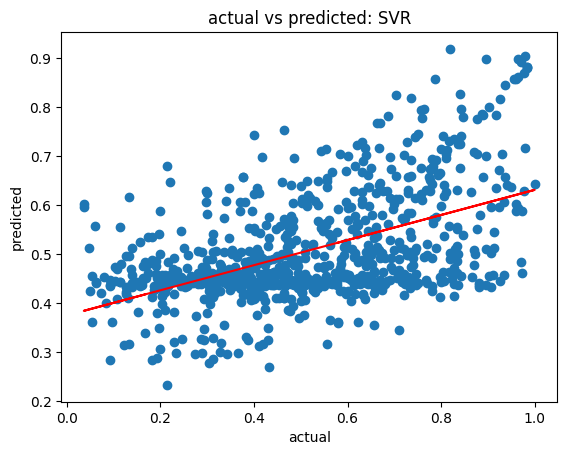

In [8]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns)

model = SVR()
model.fit(X_train_scaled[best_features], y_train)
predictions = model.predict(X_scaled[best_features])

plt.scatter(x = y, y = predictions)

a, b = np.polyfit(y, predictions, 1)
plt.plot(y, a * y + b, color = 'red')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('actual vs predicted: SVR')

In [9]:
#SVR

model = SVR()
model.fit(X_train_scaled[best_features], y_train)
predictions = model.predict(X_test_scaled[best_features])
print('MAE: ', mean_absolute_error(y_test, predictions))
print('R^2: ', r2_score(y_test, predictions))


MAE:  0.16233270328411029
R^2:  0.3005221556872205


In [10]:
#Random forest reg
model = RandomForestRegressor()
model.fit(X_train[best_features], y_train)
predictions = model.predict(X_test[best_features])
print('MAE: ', mean_absolute_error(y_test, predictions))
print('R^2: ', r2_score(y_test, predictions))

MAE:  0.16165425357873212
R^2:  0.25800515495165965


In [19]:
#feature engineering

is_best_scaled = None
best_n = None
best_MAE = 1000000000
best_features = None
best_r2 = None
best_pred = None

model = RandomForestRegressor()
model.fit(X_train, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

for n in range(2, 39):
  top_n_indices = indices[:n]
  X_train_top_n = X_train.iloc[:, top_n_indices]
  X_test_top_n = X_test.iloc[:, top_n_indices]

  model = RandomForestRegressor(random_state=42)
  model.fit(X_train_top_n, y_train)
  predictions = model.predict(X_test_top_n)
  mae = mean_absolute_error(y_test, predictions)

  if mae < best_MAE:
    is_best_scaled = False
    best_n = n
    best_MAE = mae
    best_features = X_train_top_n.columns.tolist()
    best_r2 = r2_score(y_test, predictions)
    best_pred = predictions

print('Best nr of features: ', best_n)
print('Best MAE: ', best_MAE)
print('Best R^2: ', best_r2)
print('Best feature: ', best_features)

Best nr of features:  6
Best MAE:  0.15948179959100206
Best R^2:  0.2885801873868984
Best feature:  ['Total Ratings', 'Author Fancount', 'Rating']


In [20]:
best_features

['Total Ratings', 'Author Fancount', 'Rating']

In [12]:
param_grid = {
    'n_estimators': [100,500,1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: ignored

In [21]:
model = RandomForestRegressor(n_estimators=1000, max_depth=None, min_samples_split=2, min_samples_leaf=1, bootstrap=True)
model.fit(X_train[best_features], y_train)
predictions = model.predict(X_test[best_features])
print('MAE: ', mean_absolute_error(y_test, predictions))
print('R^2: ', r2_score(y_test, predictions))

MAE:  0.1586011528386404
R^2:  0.29476299534416817


Text(0.5, 1.0, 'actual vs predicted: Random Forest Regressor')

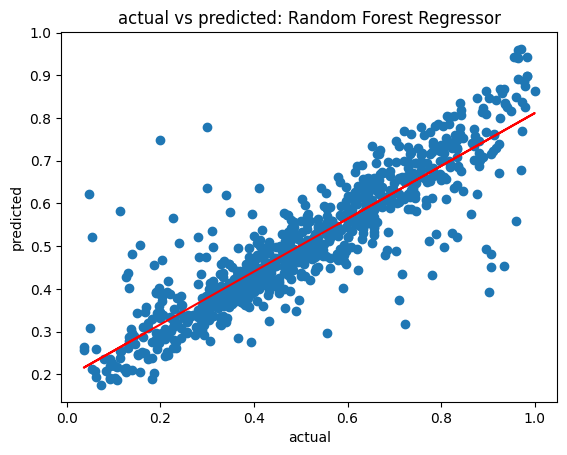

In [16]:


predictions = model.predict(X[best_features])

plt.scatter(x = y, y = predictions)

a, b = np.polyfit(y, predictions, 1)
plt.plot(y, a * y + b, color = 'red')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('actual vs predicted: Random Forest Regressor')

In [38]:
# Apply the categorization function to create a new column 'Movie Success Category'
df['Movie Success Category'] = df['Movie Success'].apply(categorize_movie_success)
df = df.drop(['Movie Success'], axis=1)

X = df.drop(columns=['Movie Success Category'], axis=1)
y = df['Movie Success Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
#Support Vector Clf tuning

param_grid = {
    'gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid, n_iter=10, cv=5)
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'gamma': 'scale'}
Best score found:  0.796923076923077


In [56]:
param_grid = {
    'C': [0.54, 0.55, 0.53]
}

random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid, n_iter=10, cv=5)
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found:  {'C': 0.54}
Best score found:  0.7984615384615384


In [59]:
model = SVC(gamma='scale', C=0.54)
model.fit(X_train[best_features], y_train)
predictions = model.predict(X_test[best_features])
print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.7607361963190185


In [71]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters found:  {'bootstrap': True}
Best score found:  0.8046153846153846


In [73]:
model = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.7668711656441718
